In [81]:
# Import necessary libraries for data handling, modeling, and visualization
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import datetime as dt


In [83]:
def fetch_data(ticker, start_date="2010-01-01"):
    end_date = dt.datetime.now().strftime('%Y-%m-%d')  
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Close']
appl_data = fetch_data('AAPL')
print(appl_data)


[*********************100%***********************]  1 of 1 completed

Date
2010-01-04      7.643214
2010-01-05      7.656429
2010-01-06      7.534643
2010-01-07      7.520714
2010-01-08      7.570714
                 ...    
2024-08-21    226.399994
2024-08-22    224.529999
2024-08-23    226.839996
2024-08-26    227.179993
2024-08-27    228.029999
Name: Close, Length: 3687, dtype: float64


In [85]:
# Normalize and prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
aapl_scaled = scaler.fit_transform(appl_data.values.reshape(-1, 1))

# Function to create data sequences for LSTM training
def create_dataset(data, look_back=100):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y).reshape(-1, 1)

# Creating the dataset for training
X, Y = create_dataset(aapl_scaled)

# Splitting data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))


In [87]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(100, 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [89]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with validation data
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0376 - val_loss: 2.6459e-04
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 3.0008e-04 - val_loss: 2.8822e-04
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.8574e-04 - val_loss: 2.5611e-04
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.6648e-04 - val_loss: 2.4048e-04
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.5211e-04 - val_loss: 2.3967e-04
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.2516e-04 - val_loss: 2.2765e-04
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.3324e-04 - val_loss: 2.6432e-04
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.3155e-04 - val_loss: 2.4227e-04
Epoch 9/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.3294e-04 - val_loss: 2.1275e-04
Epoch 10/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.2926e-04 - val_loss: 2.0087e-04
Epoch 11/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.2950e-04 - 

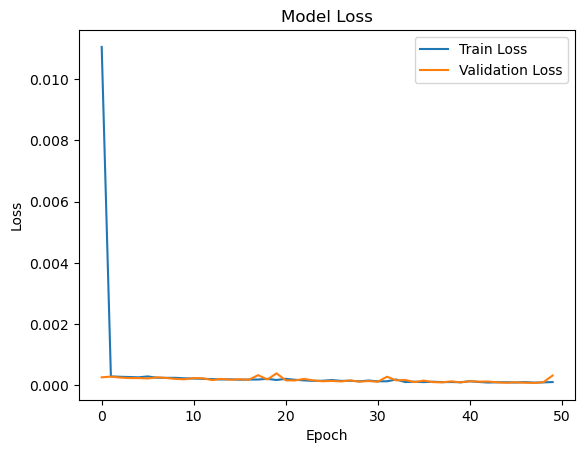

In [91]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [93]:
# Predictions on the training and validation data
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)

# Inverse scaling to transform predictions back to original scale
train_predictions = scaler.inverse_transform(train_predictions)
val_predictions = scaler.inverse_transform(val_predictions)
actual_train = scaler.inverse_transform(Y_train)
actual_val = scaler.inverse_transform(Y_val)

# Combining train and validation sets to plot them in context
all_predictions = np.concatenate((train_predictions.flatten(), val_predictions.flatten()))
all_actual = np.concatenate((actual_train.flatten(), actual_val.flatten()))

# Calculate the index for the start of validation data
train_len = len(train_predictions)


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


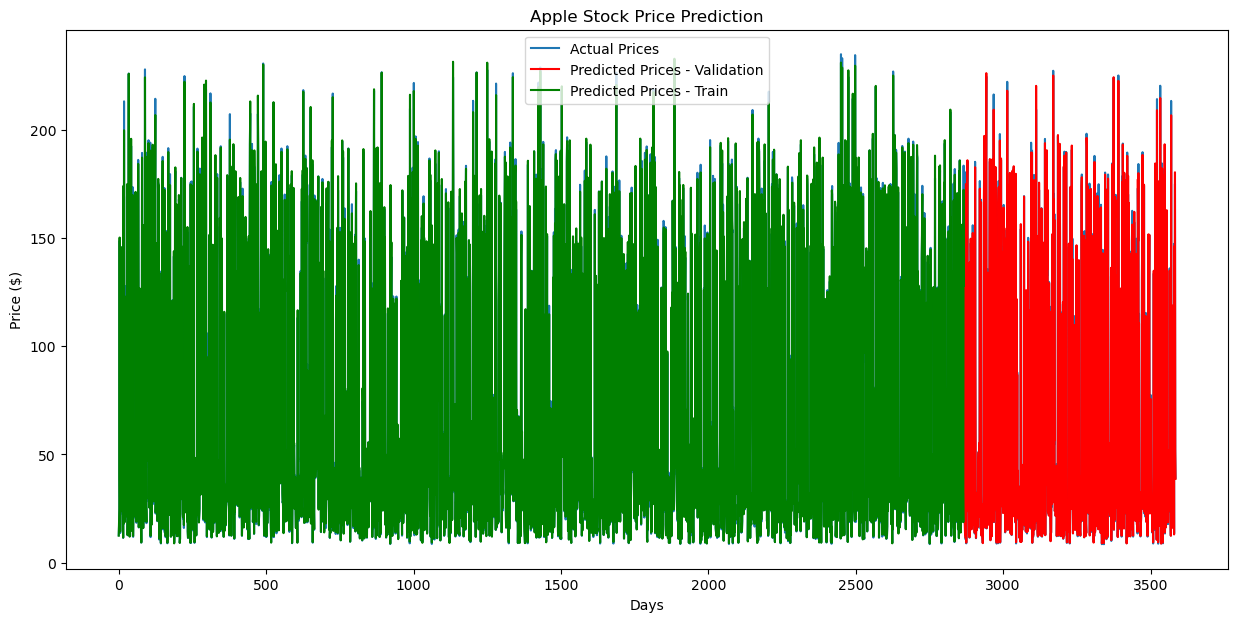

In [95]:
# Plotting the actual prices and the predictions
plt.figure(figsize=(15, 7))
plt.plot(all_actual, label='Actual Prices')
plt.plot(np.arange(train_len, train_len + len(val_predictions)), val_predictions, color='red', label='Predicted Prices - Validation')
plt.plot(np.arange(train_len), train_predictions, color='green', label='Predicted Prices - Train')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend()
plt.show()
